In [ ]:
!nvidia-smi

Sat Oct 24 10:56:44 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install -q torch==1.2.0 torchvision==0.4.0
# !pip install pillow==6.1.0

In [ ]:
%cd /content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch


/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch


In [ ]:
import argparse
import os
import torch
import torch.backends.cudnn as cudnn
from network.anomaly_detector_model import AnomalyDetector, RegularizedLoss, custom_objective
from features_loader import FeaturesLoaderVal
from network.model import static_model
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from os import path
import cv2
import numpy as np

In [ ]:
random_seed = 42
features_path = '/content/drive/My Drive/C3D_features'
annotation_path = '/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch/Test_Annotation.txt'

model_dir = ['/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch/weights/exps_mini/',
             '/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch/weights/exps_mini_noise/']


In [ ]:
for model_name in (model_dir):
  print(model_name)

/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch/weights/exps_mini/
/content/drive/My Drive/AnomalyDetectionCVPR2018-Pytorch/weights/exps_mini_noise/


In [ ]:
def get_video_length(vid_name):
    video_path = vid_name + '.mp4'
    cap = cv2.VideoCapture(video_path)
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    return length


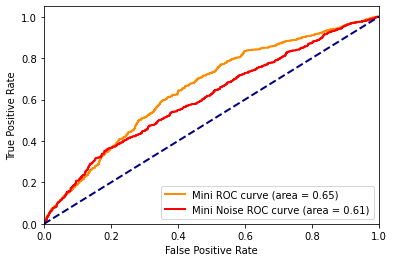

In [ ]:
if __name__ == "__main__":
  y_big_trues = []
  y_big_preds = []
  for model_number, model_name in enumerate(model_dir):
    print('#'*40)
    print('INSIDE MODEL:', model_number)
    print('#'*40)
    device = torch.device("cuda" if torch.cuda.is_available()
                          else "cpu")
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)

    data_loader = FeaturesLoaderVal(features_path=features_path,
                                    annotation_path=annotation_path)

    data_iter = torch.utils.data.DataLoader(data_loader,
                                            batch_size=1,
                                            shuffle=False,
                                            num_workers=1,  # 4, # change this part accordingly
                                            pin_memory=True)

    network = AnomalyDetector()
    network.to(device)
    net = static_model(net=network,
                       criterion=RegularizedLoss(network, custom_objective).cuda(),
                       model_prefix=model_name,
                       )
    model_path = net.get_checkpoint_path(5000)
    net.load_checkpoint(pretrain_path=model_path, epoch=5000)
    net.net.to(device)
    # net.net = torch.nn.DataParallel(net.net).cuda()

    # enable cudnn tune
    cudnn.benchmark = True

    y_trues = None
    y_preds = None

    for features, start_end_couples, feature_subpaths, lengths in tqdm(data_iter):
        # features is a batch where each item is a tensor of 32 4096D features
        features = features.to(device)
        with torch.no_grad():
            input_var = torch.autograd.Variable(features)
            outputs = net.predict(input_var)[0]  # (batch_size, 32)
            outputs = outputs.reshape(outputs.shape[0], 32)
            for vid_len, couples, output in zip(lengths, start_end_couples, outputs.cpu().numpy()):
                y_true = np.zeros(vid_len)
                segments_len = vid_len // 32
                for couple in couples:
                    if couple[0] != -1:
                        y_true[couple[0]: couple[1]] = 1
                y_pred = np.zeros(vid_len)
                for i in range(32):
                    segment_start_frame = i * segments_len
                    segment_end_frame = (i + 1) * segments_len
                    y_pred[segment_start_frame: segment_end_frame] = output[i]

                if y_trues is None:
                    y_trues = y_true
                    y_preds = y_pred
                else:
                    y_trues = np.concatenate([y_trues, y_true])
                    y_preds = np.concatenate([y_preds, y_pred])

    y_big_trues.append(y_trues)
    y_big_preds.append(y_preds)

  plt.figure(0).clf()
  lw=2
  fpr, tpr, thresholds = roc_curve(y_true=y_big_trues[0], y_score=y_big_preds[0], pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='Mini ROC curve (area = %0.2f)' % roc_auc)

  fpr, tpr, thresholds = roc_curve(y_true=y_big_trues[1], y_score=y_big_preds[1], pos_label=1)
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='red', lw=lw, label='Mini Noise ROC curve (area = %0.2f)' % roc_auc)

  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")



  if not path.exists(r'graphs'):
      os.mkdir(r'graphs')
  plt.savefig(path.join('graphs', 'minis_roc_auc.png'))
